# Prepare Data

## Import Libraries

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read csv files

In [248]:
d = pd.read_csv('train.csv')
f = pd.read_csv('test.csv')
df = pd.concat([d,f])

## Explore dataset

In [249]:
print(df.shape)
print(df.info())
df.head()

(31015, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31015 entries, 0 to 3533
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  int64  
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.6+ MB
None


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Convert Data

Convert data to help find corrleation and for data modeling stage

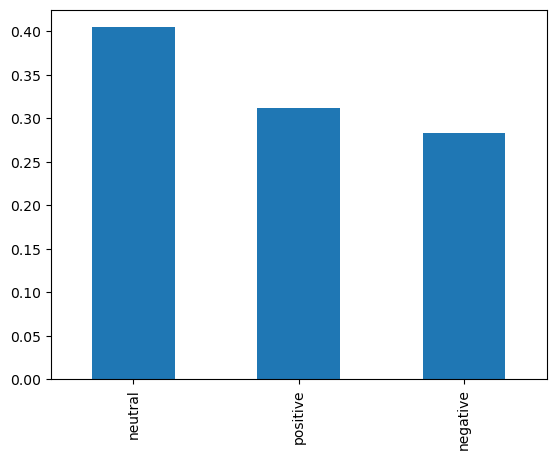

In [250]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

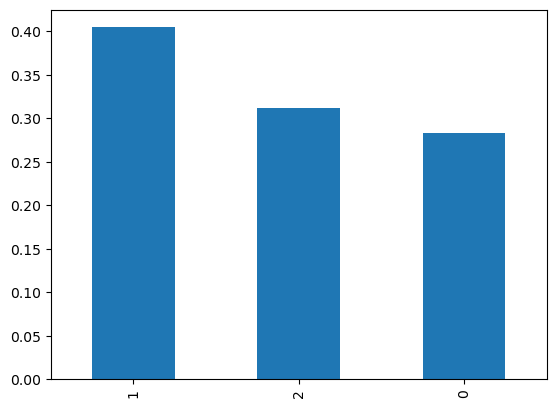

In [251]:
# Convert sentiment column to categorical variable
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

In [252]:
# Convert Time of Tweet column to categorical variable
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
# Convert Country column to categorical variable
df['Country'] = df['Country'].astype('category').cat.codes
# convert Age of User to integer 
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

In [253]:
corr = df.corr()['sentiment']
corr

sentiment           1.000000
Time of Tweet       0.000667
Age of User         0.007107
Country             0.005930
Population -2020   -0.000778
Land Area (Km²)     0.000924
Density (P/Km²)    -0.005087
Name: sentiment, dtype: float64

## Drop unuseful data

In [254]:
corr = corr.index.to_list()
del corr[0]
print(corr)

['Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']


In [255]:
# drop low corr columns from our data 
df.drop(columns=corr,inplace=True)

In [256]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


In [257]:
df.isnull().sum()

textID              0
text                1
selected_text    3535
sentiment           0
dtype: int64

## Fill null values

In [258]:
# fill empty selected with text column 
mask = df['selected_text'].isnull()
df['selected_text'][mask] =  df['text'][mask].copy()

C:\Users\zeyad\AppData\Local\Temp\ipykernel_20632\283986928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selected_text'][mask] =  df['text'][mask].copy()
C:\Users\zeyad\AppData\Local\Temp\ipykernel_20632\283986928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selected_text'][mask] =  df['text'][mask].copy()


In [259]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [260]:
df.dropna(inplace=True)

In [261]:
df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

## Creat a function to process text

In [262]:
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [263]:
df['selected_text'] = df["selected_text"].apply(wp)

# Model Building 

## Split data

In [264]:
X=df['selected_text']
y= df['sentiment']

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24811,)
(6203,)
(24811,)
(6203,)


## Convert text to vectors

In [266]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

## Baseline model

In [267]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40455923131489

## Logistic regression

In [268]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train,y_train)

LogisticRegression(n_jobs=-1)

In [269]:
pred_lr=lr.predict(XV_test)

In [270]:
# get accuracy score
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8125100757697888

In [271]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1749
           1       0.76      0.87      0.81      2502
           2       0.90      0.79      0.84      1952

    accuracy                           0.81      6203
   macro avg       0.82      0.81      0.81      6203
weighted avg       0.82      0.81      0.81      6203



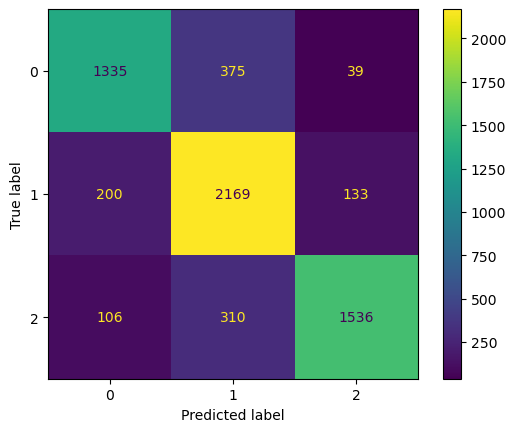

In [272]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr);

## Decision Tree Classification

In [273]:
dt = DecisionTreeClassifier()
dt.fit(XV_train, y_train)

DecisionTreeClassifier()

In [274]:
pred_dt = dt.predict(XV_test)

In [275]:
score_dt = dt.score(XV_test, y_test)
score_dt

0.730130581976463

In [276]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1749
           1       0.73      0.73      0.73      2502
           2       0.80      0.75      0.77      1952

    accuracy                           0.73      6203
   macro avg       0.73      0.73      0.73      6203
weighted avg       0.73      0.73      0.73      6203



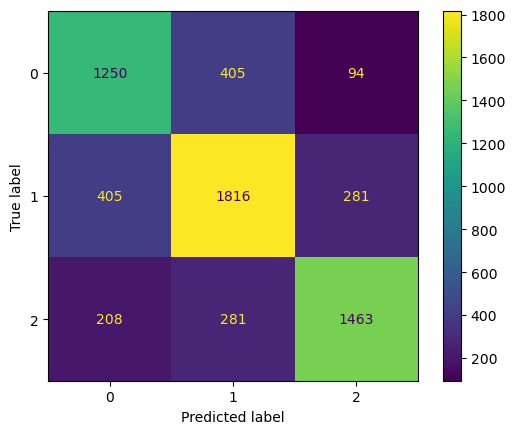

In [277]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_dt);

## Random Forest Classifier

In [278]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

RandomForestClassifier(random_state=0)

In [279]:
pred_rfc = rfc.predict(XV_test)

In [280]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

0.7849427696275996

In [281]:
print(classification_report(y_test, pred_rfc))


              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1749
           1       0.72      0.89      0.80      2502
           2       0.92      0.73      0.81      1952

    accuracy                           0.78      6203
   macro avg       0.81      0.77      0.78      6203
weighted avg       0.80      0.78      0.78      6203



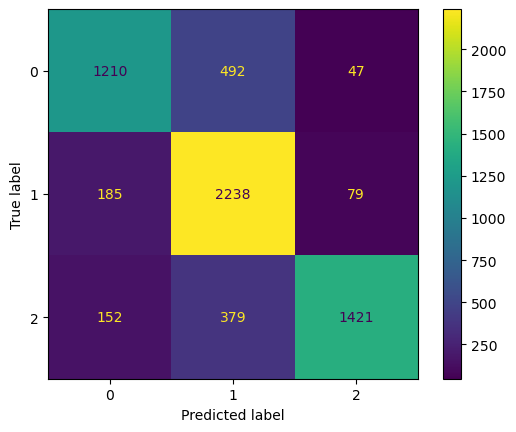

In [282]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_rfc);

## Best model in accuracy 

In [283]:
print(f'Baseline model:{score_baseline} \nLogistic regression {score_lr}\nDecision Tree Classification {score_dt}\nRandim Forest Classifier {score_rfc}')

Baseline model:0.40455923131489 
Logistic regression 0.8125100757697888
Decision Tree Classification 0.730130581976463
Randim Forest Classifier 0.7849427696275996


Our Winner is Logistic regression with accuracy equal 0.8125100757697888

# Communicate the result 


In [295]:
def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = lr.predict(new_xv_test)
    pred_dt = dt.predict(new_xv_test)
    pred_rfc = rfc.predict(new_xv_test)

    return print((output_lable(pred_lr[0])))

In [ ]:
# enter a text to find if its sentiment
text = str(input())
manual_testing(text)